This notebook is for S4 architecture building

# Settings

In [1]:
# check GPU status
!nvidia-smi

# added this to try and troubleshoot my own SCC issues
import sys
print(sys.path)
PATH = "/projectnb/perchash/venvs/dl/lib/python3.10/site-packages"
sys.path.append(PATH)

Sun Apr 21 10:02:35 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-16GB           On  |   00000000:18:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |       0MiB /  16384MiB |      0%   E. Process |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
import os.path as op

# Settings
# Presets from S4 example
n_layers=4
d_model=126 # Model dimension
dropout=0.1
prenorm=True
batch_size=64
num_workers=4

d_input = 1 # Because input is grayscale image. Make 3 for RGB
d_output = 10

# Use to load from a checkpoint
start_epoch = 0

fs = 16000

lr = 1e-2
weight_decay = 1e-2
epochs=100

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Specify the directory you want the datasets to be contained in
pdir="/projectnb/dl523/students/savageaf/project/EC523-SER/"
dataset_dir = op.join(pdir,"datasets")



# Test DataLoader

In [3]:
from torch.utils.data import DataLoader
from dataset import download_datasets, SpeechEmotionDataset, get_dataset_info

import torchaudio.transforms as t
from tqdm.auto import tqdm
import pandas as pd

# Download a single dataset
#download_datasets(dataset_dir)

# Download the rest of the datasets available
#download_datasets(dataset_dir)

# Acquire info on datasets (those that have functions to get data for)
df = get_dataset_info(dataset_dir)

# Make into a Dataset object that a pytorch optimizer can use
# Can optionally specify a sampling rate for all audio files to be in
transforms = t.Spectrogram(n_fft=400)
trainset = SpeechEmotionDataset(df, fs=16000, transform=transforms)

In [4]:
# Check it works
dataiter = iter(trainset)
data, label = next(dataiter) # this truncates automatically
label

tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=torch.uint8)

/scratch/6777302.1.academic-gpu/ipykernel_405472/1127621095.py:2: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=201).
  plt.specgram(data.numpy())


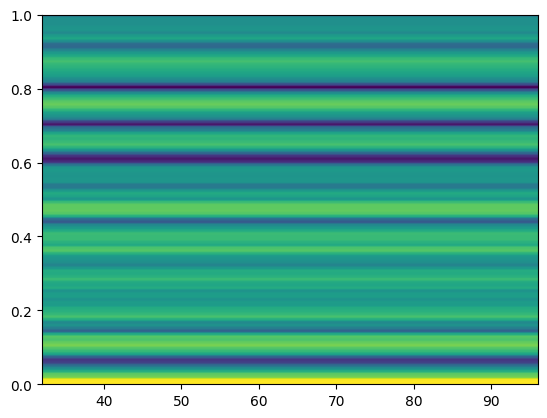

In [5]:
import matplotlib.pyplot as plt
plt.specgram(data.numpy())
plt.show()

In [6]:
from dataset import collate_fn
trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)


# Create DataLoaders for train, test, eval

In [7]:
def split_train_val(train, val_split):
    train_len = int(len(train) * (1.0-val_split))
    train, val = torch.utils.data.random_split(
        train,
        (train_len, len(train) - train_len),
        generator=torch.Generator().manual_seed(42),
    )
    return train, val



# Specify transforms to use
transforms = t.Spectrogram(n_fft=400)

# Make trainset
trainset = SpeechEmotionDataset(df, fs=fs, transform=transforms, train=True)
trainset, _ = split_train_val(trainset, val_split=0.1)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=collate_fn)

# Make valset
valset = SpeechEmotionDataset(df, fs=fs, transform=transforms, train=True)
_, valset = split_train_val(valset, val_split=0.1)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)

# Make testset
testset = SpeechEmotionDataset(df, fs=fs, transform=transforms, train=False)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)

In [8]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

X = df['filename'] # extracts filenames from info dataframe
#column_headers = df.columns
shared_emotions = ['anger', 'happy', 'neutral', 'sadness'] # the emotions that are common to all databases
filtered_df = df[df['emotion'].isin(shared_emotions)]
filtered_df = filtered_df.reset_index(drop=True) # dataframe with only shared emotions

# Label encoding
label_encoder = LabelEncoder()
integer_encoding = label_encoder.fit_transform(filtered_df['emotion']) # encoding indices of one hot vectors as ints

# Binary encoding
one_hot_encoder = OneHotEncoder(sparse_output=False)
integer_encoding = integer_encoding.reshape(-1, 1) # nested list
one_hot_encoding = one_hot_encoder.fit_transform(integer_encoding) # show corresponding one-hot vectors

# One-hot encoding to DataFrame
one_hot_df = pd.DataFrame(one_hot_encoding, columns=label_encoder.classes_)
result_df = pd.concat([filtered_df['filename'], one_hot_df], axis=1)

# Combining emotions into one array for each file name (drop individual one-hot encoded columns)
result_df['emotion_onehot'] = result_df.iloc[:, 1:].values.tolist()
result_df.drop(result_df.columns[1:-1], axis=1, inplace=True)

# print("Current dataframe: ")
print(result_df)

                                                filename        emotion_onehot
0      /projectnb/dl523/students/savageaf/project/EC5...  [0.0, 0.0, 1.0, 0.0]
1      /projectnb/dl523/students/savageaf/project/EC5...  [0.0, 0.0, 1.0, 0.0]
2      /projectnb/dl523/students/savageaf/project/EC5...  [0.0, 0.0, 1.0, 0.0]
3      /projectnb/dl523/students/savageaf/project/EC5...  [0.0, 0.0, 1.0, 0.0]
4      /projectnb/dl523/students/savageaf/project/EC5...  [1.0, 0.0, 0.0, 0.0]
...                                                  ...                   ...
10543  /projectnb/dl523/students/savageaf/project/EC5...  [0.0, 0.0, 1.0, 0.0]
10544  /projectnb/dl523/students/savageaf/project/EC5...  [0.0, 0.0, 1.0, 0.0]
10545  /projectnb/dl523/students/savageaf/project/EC5...  [1.0, 0.0, 0.0, 0.0]
10546  /projectnb/dl523/students/savageaf/project/EC5...  [0.0, 0.0, 1.0, 0.0]
10547  /projectnb/dl523/students/savageaf/project/EC5...  [1.0, 0.0, 0.0, 0.0]

[10548 rows x 2 columns]


In [9]:
from dataset import SoundDS
from torch.utils.data import Dataset, DataLoader, random_split

# result_df consists of filename and the one-hot encoded emotions
dataset = SoundDS(result_df)

# Random split with ratios of 70% training, 10% validation, and 20% testing
total_items = len(dataset)
train_size = round(total_items * 0.7)
val_size = round(total_items * 0.1)
test_size = total_items - train_size - val_size

# Checking dataset split
print("Size of dataset: ", total_items)
print("Size of Training data (%): ", train_size / total_items * 100)
print("Size of Testing data (%): ", test_size / total_items * 100)
print("Size of Validation data (%): ", val_size / total_items * 100)

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# Create training and validation data loaders
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

Size of dataset:  10548
Size of Training data (%):  70.00379218809253
Size of Testing data (%):  19.994311717861205
Size of Validation data (%):  10.001896094046264


Shape of sample_data:  (batch_sz, num_channels, Mel freq_bands, time_steps) torch.Size([16, 1, 64, 126])
Shape of Mel Spectrogram: (num_channels, Mel freq_bands, time_steps in spec) torch.Size([1, 64, 126]) 



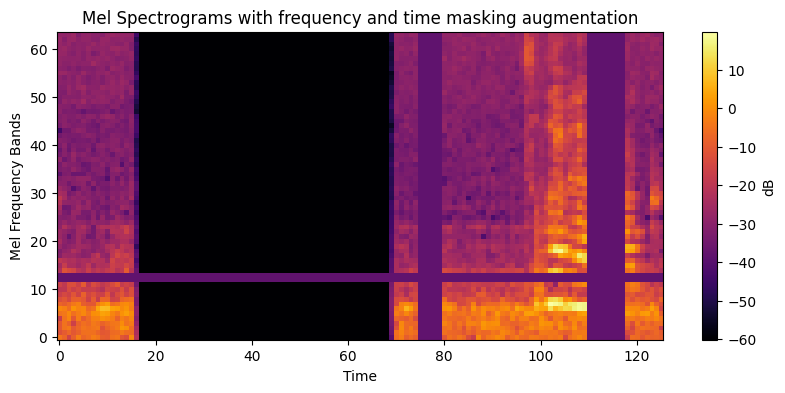

In [10]:
import random

# Check size of mel spectrogram at the end: 
# e.g. (num_channels, Mel freq_bands, time_steps in spec) = (2, 64, 344)
sample_data, _ = next(iter(train_loader))
print("Shape of sample_data: ", "(batch_sz, num_channels, Mel freq_bands, time_steps)", sample_data.shape)
# torch.Size([16, 1, 64, 126])

mel_spectrogram = sample_data[0]

mel_shape = mel_spectrogram.shape
print("Shape of Mel Spectrogram:", "(num_channels, Mel freq_bands, time_steps in spec)", mel_shape, "\n")
# torch.Size([1, 64, 126])

# Spectrogram for 1st channel
mel_spectrogram = sample_data[0]

mel_spectrogram = mel_spectrogram.squeeze()

# Plot the Mel Spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(mel_spectrogram.numpy(), cmap='inferno', origin='lower')

n_freq_masks = 2
n_time_masks = 2

# Overlay frequency and time masking
for _ in range(n_freq_masks):
    freq_mask_range = torch.randint(1, mel_spectrogram.size(0)//2, (1,)).item()
    freq_mask_start = torch.randint(0, mel_spectrogram.size(0) - freq_mask_range, (1,)).item()
    mel_spectrogram[freq_mask_start:freq_mask_start+freq_mask_range, :] = mel_spectrogram.mean()

for _ in range(n_time_masks):
    time_mask_range = torch.randint(1, mel_spectrogram.size(1)//2, (1,)).item()
    time_mask_start = torch.randint(0, mel_spectrogram.size(1) - time_mask_range, (1,)).item()
    mel_spectrogram[:, time_mask_start:time_mask_start+time_mask_range] = mel_spectrogram.mean()

plt.title('Mel Spectrograms with frequency and time masking augmentation')
plt.xlabel('Time')
plt.ylabel('Mel Frequency Bands')
plt.colorbar(label='dB')
plt.show()

# Create S4 model

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
#from s4.models.s4.s4d import S4D
from models.s4.s4d import S4D


# Dropout broke in PyTorch 1.11
if tuple(map(int, torch.__version__.split('.')[:2])) == (1, 11):
    print("WARNING: Dropout is bugged in PyTorch 1.11. Results may be worse.")
    dropout_fn = nn.Dropout
if tuple(map(int, torch.__version__.split('.')[:2])) >= (1, 12):
    dropout_fn = nn.Dropout1d
else:
    dropout_fn = nn.Dropout2d
    

class S4Model(nn.Module):

    def __init__(
        self,
        d_input,
        d_output=10,
        d_model=256,
        n_layers=4,
        dropout=0.2,
        prenorm=False,
        lr=1-2
    ):
        super().__init__()

        self.prenorm = prenorm

        # Linear encoder (d_input = 1 for grayscale and 3 for RGB)
        self.encoder = nn.Linear(d_input, d_model)
        #self.encoder = nn.Linear(d_model, d_input)

        # Stack S4 layers as residual blocks
        self.s4_layers = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        for _ in range(n_layers):
            self.s4_layers.append(
                S4D(d_model, dropout=dropout, transposed=True, lr=min(0.001, lr))
            )
            self.norms.append(nn.LayerNorm(d_model))
            self.dropouts.append(dropout_fn(dropout))

        # Linear decoder
        self.decoder = nn.Linear(d_model, d_output)

    def forward(self, x):
        """
        Input x is shape (B, L, d_input)
        """
        x = self.encoder(x)  # (B, L, d_input) -> (B, L, d_model)

        x = x.transpose(-1, -2)  # (B, L, d_model) -> (B, d_model, L)
        for layer, norm, dropout in zip(self.s4_layers, self.norms, self.dropouts):
            # Each iteration of this loop will map (B, d_model, L) -> (B, d_model, L)

            z = x
            if self.prenorm:
                # Prenorm
                z = norm(z.transpose(-1, -2)).transpose(-1, -2)

            # Apply S4 block: we ignore the state input and output
            z, _ = layer(z)

            # Dropout on the output of the S4 block
            z = dropout(z)

            # Residual connection
            x = z + x

            if not self.prenorm:
                # Postnorm
                x = norm(x.transpose(-1, -2)).transpose(-1, -2)

        x = x.transpose(-1, -2)

        # Pooling: average pooling over the sequence length
        x = x.mean(dim=1)

        # Decode the outputs
        x = self.decoder(x)  # (B, d_model) -> (B, d_output)

        return x


In [12]:
# Model
print('==> Building model..')
model = S4Model(
    d_input=d_input,
    d_output=d_output,
    d_model=d_model,
    n_layers=n_layers,
    dropout=dropout,
    prenorm=prenorm,
    lr=lr
)

model = model.to(device)
if device == 'cuda':
    cudnn.benchmark = True

==> Building model..


/usr3/graduate/savageaf/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


# Setup Optimizer and Loss function

In [13]:
def setup_optimizer(model, lr, weight_decay, epochs):
    """
    S4 requires a specific optimizer setup.

    The S4 layer (A, B, C, dt) parameters typically
    require a smaller learning rate (typically 0.001), with no weight decay.

    The rest of the model can be trained with a higher learning rate (e.g. 0.004, 0.01)
    and weight decay (if desired).
    """

    # All parameters in the model
    all_parameters = list(model.parameters())

    # General parameters don't contain the special _optim key
    params = [p for p in all_parameters if not hasattr(p, "_optim")]

    # Create an optimizer with the general parameters
    optimizer = optim.AdamW(params, lr=lr, weight_decay=weight_decay)

    # Add parameters with special hyperparameters
    hps = [getattr(p, "_optim") for p in all_parameters if hasattr(p, "_optim")]
    hps = [
        dict(s) for s in sorted(list(dict.fromkeys(frozenset(hp.items()) for hp in hps)))
    ]  # Unique dicts
    for hp in hps:
        params = [p for p in all_parameters if getattr(p, "_optim", None) == hp]
        optimizer.add_param_group(
            {"params": params, **hp}
        )

    # Create a lr scheduler
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=0.2)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

    # Print optimizer info
    keys = sorted(set([k for hp in hps for k in hp.keys()]))
    for i, g in enumerate(optimizer.param_groups):
        group_hps = {k: g.get(k, None) for k in keys}
        print(' | '.join([
            f"Optimizer group {i}",
            f"{len(g['params'])} tensors",
        ] + [f"{k} {v}" for k, v in group_hps.items()]))

    return optimizer, scheduler

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer, scheduler = setup_optimizer(
    model, lr=lr, weight_decay=weight_decay, epochs=epochs
)

Optimizer group 0 | 28 tensors | lr 0.01 | weight_decay 0.01
Optimizer group 1 | 12 tensors | lr 0.001 | weight_decay 0.0


# Set train() function

In [15]:
def train():
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    batch_idx = 0
    for inputs, targets in tqdm(train_loader):
        batch_idx +=1
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        pbar.set_description(
            'Batch Idx: (%d/%d) | Loss: %.3f | Acc: %.3f%% (%d/%d)' %
            (batch_idx, len(trainloader), train_loss/(batch_idx+1), 100.*correct/total, correct, total)
        )

# Set eval() function

In [16]:
def eval(epoch, dataloader, checkpoint=False):
    global best_acc
    model.eval()
    eval_loss = 0
    correct = 0
    total = 0
    i = 0
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader):
            batch_idx += 1
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            eval_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            pbar.set_description(
                'Batch Idx: (%d/%d) | Loss: %.3f | Acc: %.3f%% (%d/%d)' %
                (batch_idx, len(dataloader), eval_loss/(batch_idx+1), 100.*correct/total, correct, total)
            )

    # Save checkpoint.
    if checkpoint:
        acc = 100.*correct/total
        if acc > best_acc:
            state = {
                'model': model.state_dict(),
                'acc': acc,
                'epoch': epoch,
            }
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            torch.save(state, './checkpoint/ckpt.pth')
            best_acc = acc

        return acc

# Run training and evaluation

In [17]:
pbar = tqdm(range(start_epoch, epochs))
for epoch in pbar:
    if epoch == 0:
        pbar.set_description('Epoch: %d' % (epoch))
    else:
        pbar.set_description('Epoch: %d | Val acc: %1.3f' % (epoch, val_acc))
    train()
    val_acc = eval(epoch, val_loader, checkpoint=True)
    eval(epoch, test_loader)
    scheduler.step()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1024x126 and 1x126)